In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModel
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, classification_report


/Users/xisco/anaconda3/envs/dl/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
tr = pd.read_csv('train.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
ev = pd.read_csv('evaluation.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
test = pd.read_csv('test.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})

dataset = pd.concat([tr, ev, test], axis=0, ignore_index=True)

In [4]:
print('Nombre de las columnas:\n', dataset.columns)
print('\nDimensiones de los datos: ', dataset.shape)
print('\nValores ausentes:\n', dataset.isnull().sum())

Nombre de las columnas:
 Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

Dimensiones de los datos:  (40587, 4)

Valores ausentes:
 Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


La columna Unnamed: 0 contiene la posición en la base de datos de cada muestra. No es relevante para el estudio y se va a eliminar de la base de datos.

In [5]:
dataset = dataset.drop(columns=['Unnamed: 0'])
print(dataset.shape)

(40587, 3)


# Análisis exploratorio

## Análisis de la característica title

In [6]:
freq = dataset.value_counts('title')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de title"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de title
0            1                       39605
1            2                         375
2            3                           9
3            4                           2
4          153                           1
5           14                           1
6           11                           1
7            8                           1
8            6                           1
9            5                           1


Como podemos ver la mayoría de titulares de noticia son únicos, es decir, que aparecen una única vez. Los titulares con más de una aparición puede que se deba a que se hayan cogido diferentes fragmentos de una noticia como muestras distintas, pero el titular se comparte entre ellas. En caso de que no fuera así y hubiera muestras repetidas lo podríamos comprobar cuando analicemos la característica text. Si comparte las mismas apariciones que esta característica significará que hay muestras repetidas y las eliminaremos de la base de datos.

## Análisis de la característica text

In [7]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40583
1            2                          2


Podemos ver que solo hay dos pares de muestras repetidas lo que confirma nuestra teoría para la característica title. Por lo tanto, únicamente tenemos que eliminar una de las muestras de cada par duplicado.

In [8]:
dataset = dataset.drop_duplicates(subset='text', keep='first')

In [9]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40585


In [10]:
num_palabras = dataset['text'].apply(lambda x: len(str(x).split()))
media_palabras = num_palabras.mean()

min_palabras = num_palabras.min()
max_palabras = num_palabras.max()

cantidad_50_o_menos = (num_palabras <= 50).sum()

print("Media de palabras:", media_palabras)
print("Mínimo número de palabras:", min_palabras)
print("Máximo número de palabras:", max_palabras)
print("Número de muestras con 50 palabras o menos:", cantidad_50_o_menos)

Media de palabras: 407.95843291856596
Mínimo número de palabras: 0
Máximo número de palabras: 8135
Número de muestras con 50 palabras o menos: 1527


Q1: 211.0
Q2 (mediana): 367.0
Q3: 514.0
Media: 407.95843291856596


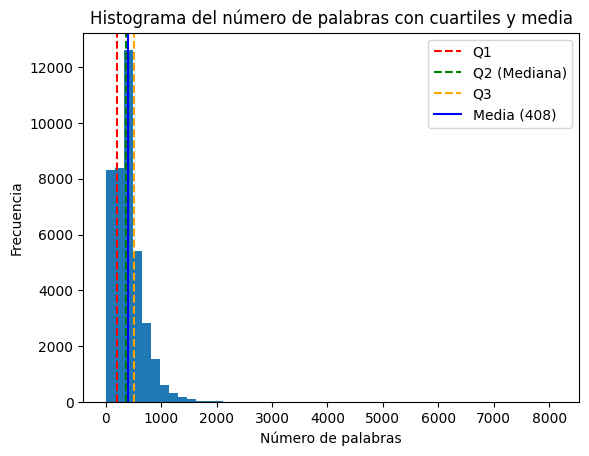

In [11]:
q1 = num_palabras.quantile(0.25)
q2 = num_palabras.quantile(0.50)   # mediana
q3 = num_palabras.quantile(0.75)

print("Q1:", q1)
print("Q2 (mediana):", q2)
print("Q3:", q3)
print("Media:", num_palabras.mean())  # debería ser 408

plt.hist(num_palabras, bins=50)
plt.axvline(q1, color='red', linestyle='--', label='Q1')
plt.axvline(q2, color='green', linestyle='--', label='Q2 (Mediana)')
plt.axvline(q3, color='orange', linestyle='--', label='Q3')
plt.axvline(408, color='blue', linestyle='-', label='Media (408)')

plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma del número de palabras con cuartiles y media')
plt.legend()
plt.show()


Quitamos las muestras con menos de 50 palabras al no ser suficientemente largo para el modelo, además de recortar los textos que son muy largos con un máximo de 1000 palabras

In [12]:
dataset = dataset[num_palabras >= 100].reset_index(drop=True)
print(dataset.shape)


def recortar_texto(texto, limite=1000):
    palabras = str(texto).split()
    if len(palabras) > limite:
        palabras = palabras[:limite]
    return " ".join(palabras)

dataset["text"] = dataset["text"].apply(recortar_texto)
num_palabras = dataset["text"].apply(lambda x: len(str(x).split()))
print("Máximo número de palabras ahora:", num_palabras.max())



(35241, 3)
Máximo número de palabras ahora: 1000


## Análisis de la característica label

In [13]:
freq = dataset.value_counts('label')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de label"]
print(dataset['label'].value_counts(normalize=True) * 100)
print(df_histograma_frecuencias)

label
1    51.607503
0    48.392497
Name: proportion, dtype: float64
   Apariciones  Número de valores de label
0        18187                           1
1        17054                           1


<Axes: >

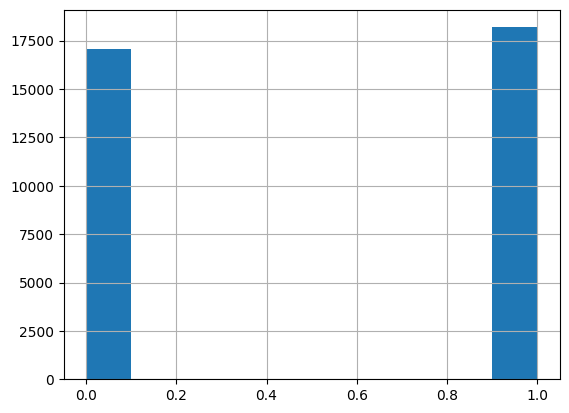

In [14]:
dataset['label'].hist()

Podemos ver que más o menos tenemos la misma cantidad de muestras con etiqueta 0 y 1, convirtiendo esta base de datos en adecuada para el entrenamiento de una red neuronal.

Separamos la base de datos en tres: entrenamiento, validación y test

In [15]:
dataset = dataset.drop(index=0).reset_index(drop=True)

# 10% train, 90% temp
train, temp = train_test_split(dataset, test_size=0.90, random_state=42)
# El 90% restante se divide en 50/50 -> 45% val, 45% test
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)

# Separar características y etiquetas
X_train = train.drop(columns=['label'])
y_train = train['label']

X_val = val.drop(columns=['label'])
y_val = val['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Comprobar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


(3524, 3)
(15858, 3)
(15858, 3)
X_train: (3524, 2) y_train: (3524,)
X_val: (15858, 2) y_val: (15858,)
X_test: (15858, 2) y_test: (15858,)


# Modelado de un algoritmo de clasificación

Hemos decidido utilizar el algoritmo X para comparar su desempeño con nuestra red nueronal

In [16]:
#Usamos solo la columna 'text' como entrada de texto
X_train_text = X_train["text"]
X_val_text = X_val["text"]
X_test_text = X_test["text"]

#Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [17]:
#Modelo de scikit-learn (RandomForest como decías)
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train_tfidf, y_train)

#Evaluación en validación y test
y_val_pred = clf.predict(X_val_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

print("=== Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("=== Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Validación ===
Accuracy val: 0.9739563627191323
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7756
           1       0.98      0.97      0.97      8102

    accuracy                           0.97     15858
   macro avg       0.97      0.97      0.97     15858
weighted avg       0.97      0.97      0.97     15858

=== Test ===
Accuracy test: 0.9766679278597553
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7600
           1       0.98      0.97      0.98      8258

    accuracy                           0.98     15858
   macro avg       0.98      0.98      0.98     15858
weighted avg       0.98      0.98      0.98     15858



Obtenemos unos resultados extrañamente buenos. Antes de continuar analicemos las variables (que seran los tokens) que más peso tienen en la decisión del algoritmo de clasificación Random Forest

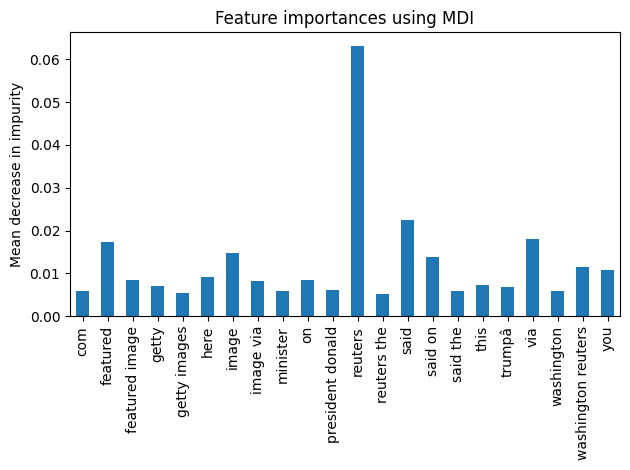

In [18]:
importances = clf.feature_importances_
feature_index = [i for i in range(X_train_tfidf.shape[1])]
words = [ p for p in vectorizer.get_feature_names_out()[feature_index] ]

filtro = importances > 0.005
relevant = importances[filtro] # Las importances que cumplen el filtro
relevant_words = np.array(words)[filtro] # Las palabras que cumplen el filtro

forest_importances = pd.Series(relevant, index=relevant_words)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Vemos que la palabra más importante es "reuters" que resulta ser el nombre de una agencia de noticias. Veamos que noticias tienen la palabra "reuters" y que coincidencia tienen con "label". Añadimos una nueva columna "reuters" que será 1 si el texto tiene la palabra "reuters" y 0 en otro caso.

In [19]:
dataset["reuters"] = dataset["text"].str.contains("reuters", case=False, na=False).astype(int)

In [20]:
print("Coincidencias: ", (dataset['label']==dataset['reuters']).sum()/len(dataset)*100 )


Coincidencias:  97.7383654937571


Vemos que en el 97,7% de las noticias, la columna label coincide con la columna reuters. Por tanto un clasificador tan sencillo como que devuelva 1 (noticia verdadera) cuando aparece la palabra "reuters" y 0 en otro caso (noticia falsa) ya tendría una tasa de acierto del 97,7%. Eso es por la contrucción del conjunto de datos, seguramente las noticias verdaderas salen de esta agencia de noticias y estan firmadas. Veamos algunos ejemplos

In [21]:
print( pd.DataFrame( { "text": dataset["text"].str[:50] + "...", 
                       "label": dataset["label"],
                       "reuters": dataset["reuters"] } ).head(30) )

                                                     text  label  reuters
0   While the controversy over Trump s personal tax re...      0        0
1   BEIJING (Reuters) - A trip to Beijing last week by...      1        1
2   There has never been a more UNCOURAGEOUS person in...      0        0
3   BAUCHI, Nigeria (Reuters) - Suspected Boko Haram s...      1        1
4   John Oliver isn t known for mincing words when it ...      0        0
5   WASHINGTON (Reuters) - Nine Democratic senators as...      1        1
6   Donald Trump sure knows how to add insult to injur...      0        0
7   I know Patty and I are boycotting Macy s for dumpi...      0        0
8   SEOUL/TOKYO (Reuters) - Detonating a nuclear-tippe...      1        1
9   PRAGUE (Reuters) - Czech police have requested par...      1        1
10  Trump is going to win in a landslide, but wouldn t...      0        0
11  Ted Cruz accused Senator Al Franken of lying about...      0        0
12  WASHINGTON/NEW YORK (Reuters) - As

Claramente la palabra "reuters" resulta una pista demasiado fácil para el clasificador. Si tiene la palabra "reuters" es verdadera y si no es falsa. Si entrenamos un clasificador con estos datos aprenderá atajos propios de los datos y difícilmente generalizará para otras noticias que no sigan el mismo patrón, pero que también pueden ser verdaderas. Para evitar este sesgo, eliminamos esta palabra.

In [22]:
dataset["text_without_reuters"] = dataset["text"].str.lower().str.replace("reuters", "")

Repetimos el algoritmo sobre la columna "text_without_reuters"

In [23]:
dataset = dataset.drop(index=0).reset_index(drop=True)

# 10% train, 90% temp
train, temp = train_test_split(dataset, test_size=0.95, random_state=42)
# El 90% restante se divide en 50/50 -> 45% val, 45% test
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)

# Separar características y etiquetas
X_train = train.drop(columns=['label'])
y_train = train['label']

X_val = val.drop(columns=['label'])
y_val = val['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Comprobar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


(1761, 5)
(16739, 5)
(16739, 5)
X_train: (1761, 4) y_train: (1761,)
X_val: (16739, 4) y_val: (16739,)
X_test: (16739, 4) y_test: (16739,)


In [24]:
#Usamos solo la columna 'text_without_reuter' como entrada de texto
X_train_text = X_train["text_without_reuters"]
X_val_text = X_val["text_without_reuters"]
X_test_text = X_test["text_without_reuters"]

#Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [25]:
#Modelo de scikit-learn (RandomForest como decías)
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train_tfidf, y_train)

#Evaluación en validación y test
y_val_pred = clf.predict(X_val_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

print("=== Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("=== Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Validación ===
Accuracy val: 0.9542386044566581
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8112
           1       0.95      0.97      0.96      8627

    accuracy                           0.95     16739
   macro avg       0.95      0.95      0.95     16739
weighted avg       0.95      0.95      0.95     16739

=== Test ===
Accuracy test: 0.951430790369795
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      8101
           1       0.94      0.97      0.95      8638

    accuracy                           0.95     16739
   macro avg       0.95      0.95      0.95     16739
weighted avg       0.95      0.95      0.95     16739



La precisión del algoritmo ha bajado, pero no de forma espectacular. Analicemos de nuevo los tokens que más han influido en el clasificador:

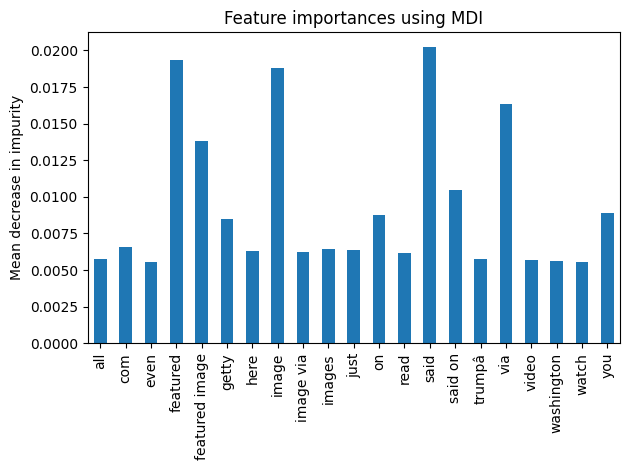

In [26]:
importances = clf.feature_importances_
feature_index = [i for i in range(X_train_tfidf.shape[1])]
words = [ p for p in vectorizer.get_feature_names_out()[feature_index] ]

filtro = importances > 0.005
relevant = importances[filtro]
relevant_words = np.array(words)[filtro]

forest_importances = pd.Series(relevant, index=relevant_words)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Vemos que palabras como "said", "said on" o "said the" influyen en la decisión. Seguramente porque las noticias reales citan a otros. Este criterio parece sensato y no procede modificar más los datos.

In [27]:
# Vectorizador Word2Vec
def tokenize(text):
    return text.lower().split()

X_train_tokens = X_train_text.apply(tokenize)
X_val_tokens = X_val_text.apply(tokenize)
X_test_tokens = X_test_text.apply(tokenize)

w2v_model = Word2Vec(
    sentences=X_train_tokens.tolist(),  # lista de listas de tokens
    vector_size=300,     # dimensión del embedding
    window=5,            # contexto
    min_count=2,         # ignora palabras con frecuencia < 2
    workers=4,           # hilos
    sg=1,                # 1 = skip-gram, 0 = CBOW
    epochs=10,
    seed=42
)

def document_vector(doc_tokens, model):
    # Nos quedamos solo con las palabras que estén en el vocabulario
    vectors = [model.wv[token] for token in doc_tokens if token in model.wv]
    if len(vectors) == 0:
        # Si ninguna palabra está en el vocabulario, devolvemos un vector de ceros
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

def docs_to_matrix(docs_tokens, model):
    return np.vstack([document_vector(tokens, model) for tokens in docs_tokens])

X_train_w2v = docs_to_matrix(X_train_tokens, w2v_model)
X_val_w2v = docs_to_matrix(X_val_tokens, w2v_model)
X_test_w2v = docs_to_matrix(X_test_tokens, w2v_model)

print("X_train_w2v shape:", X_train_w2v.shape)
print("X_val_w2v shape:", X_val_w2v.shape)
print("X_test_w2v shape:", X_test_w2v.shape)



X_train_w2v shape: (1761, 300)
X_val_w2v shape: (16739, 300)
X_test_w2v shape: (16739, 300)


Entrenar el clasificador con los vectores Word2Vec

In [28]:
clf_w2v = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

clf_w2v.fit(X_train_w2v, y_train)

# Predicciones
y_val_pred_w2v = clf_w2v.predict(X_val_w2v)
y_test_pred_w2v = clf_w2v.predict(X_test_w2v)

print("=== Word2Vec + RandomForest | Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred_w2v))
print(classification_report(y_val, y_val_pred_w2v))

print("=== Word2Vec + RandomForest | Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred_w2v))
print(classification_report(y_test, y_test_pred_w2v))


=== Word2Vec + RandomForest | Validación ===
Accuracy val: 0.9394229045940617
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8112
           1       0.93      0.95      0.94      8627

    accuracy                           0.94     16739
   macro avg       0.94      0.94      0.94     16739
weighted avg       0.94      0.94      0.94     16739

=== Word2Vec + RandomForest | Test ===
Accuracy test: 0.937093016309218
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8101
           1       0.93      0.95      0.94      8638

    accuracy                           0.94     16739
   macro avg       0.94      0.94      0.94     16739
weighted avg       0.94      0.94      0.94     16739



# Modelo Transformer

In [29]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def encode_texts(texts, tokenizer, model, batch_size=16, max_length=128):
    """
    texts: lista/Serie de strings
    return: matriz numpy (n_docs, hidden_size)
    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = list(texts[i:i + batch_size])

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # [batch_size, seq_len, hidden_size]
            last_hidden_state = outputs.last_hidden_state
            # Usamos el token CLS como embedding del documento
            cls_embeddings = last_hidden_state[:, 0, :]  # (batch_size, hidden_size)

        all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
X_train_text = X_train["text"]
X_val_text = X_val["text"]
X_test_text = X_test["text"]

X_train_bert = encode_texts(X_train_text, tokenizer, model)
X_val_bert = encode_texts(X_val_text, tokenizer, model)
X_test_bert = encode_texts(X_test_text, tokenizer, model)

print("X_train_bert shape:", X_train_bert.shape)
print("X_val_bert shape:", X_val_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)


X_train_bert shape: (1761, 768)
X_val_bert shape: (16739, 768)
X_test_bert shape: (16739, 768)


Ahora clasificamos sobre los embeddings

In [31]:
clf_bert = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

clf_bert.fit(X_train_bert, y_train)

# Predicciones
y_val_pred_bert = clf_bert.predict(X_val_bert)
y_test_pred_bert = clf_bert.predict(X_test_bert)

print("=== BERT embeddings + RandomForest | Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred_bert))
print(classification_report(y_val, y_val_pred_bert))

print("=== BERT embeddings + RandomForest | Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred_bert))
print(classification_report(y_test, y_test_pred_bert))


=== BERT embeddings + RandomForest | Validación ===
Accuracy val: 0.9501164944142422
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8112
           1       0.96      0.94      0.95      8627

    accuracy                           0.95     16739
   macro avg       0.95      0.95      0.95     16739
weighted avg       0.95      0.95      0.95     16739

=== BERT embeddings + RandomForest | Test ===
Accuracy test: 0.945217754943545
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8101
           1       0.96      0.94      0.95      8638

    accuracy                           0.95     16739
   macro avg       0.95      0.95      0.95     16739
weighted avg       0.95      0.95      0.95     16739

